### 1. Necessary libraries

In [488]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### 2. Data import

In [489]:
data = pd.read_csv('take_rate-2.csv')

In [490]:
data.head()

,MASTER_CUSTOMER_NAME,OEM_NAME,SALES_MARKET,SALES_SEGMENT,FISCAL_QUARTER,MDS_VALUE,REVENUE,TakeRate,Order_Date
0,77 ELEKTRONIKA KFT,ROCHE DIAGNOSTICS,Medical,Monitoring - Personal,FY17-Q1,0,1806,0.000000,1/2/2017
1,ATHER ENERGY PRIVATE LIMITED,ATHER ENERGY PRIVATE LIMITED,Automotive,Instrumentation,FY17-Q1,4156,0,0.000000,1/2/2017
2,BLOOM ENERGY,BLOOM ENERGY,Industrial & Semiconductors,Control & Process,FY17-Q1,287205,186315,0.648718,1/2/2017
3,BLOOM ENERGY,BLOOM ENERGY,Control & Process,Industrial & Semiconductors,FY17-Q1,251546,0,0.000000,1/2/2017
4,BLOOM ENERGY,BLOOM ENERGY (INDIA) PVT. LTD.,Industrial & Semiconductors,Control & Process,FY17-Q1,165550,0,0.000000,1/2/2017


In [491]:
data.shape

(497, 9)

### 3. Exploratory data analysis

In [492]:
data.isnull().sum()

MASTER_CUSTOMER_NAME    0
OEM_NAME                0
SALES_MARKET            0
SALES_SEGMENT           0
FISCAL_QUARTER          0
MDS_VALUE               0
REVENUE                 0
TakeRate                0
Order_Date              0
dtype: int64

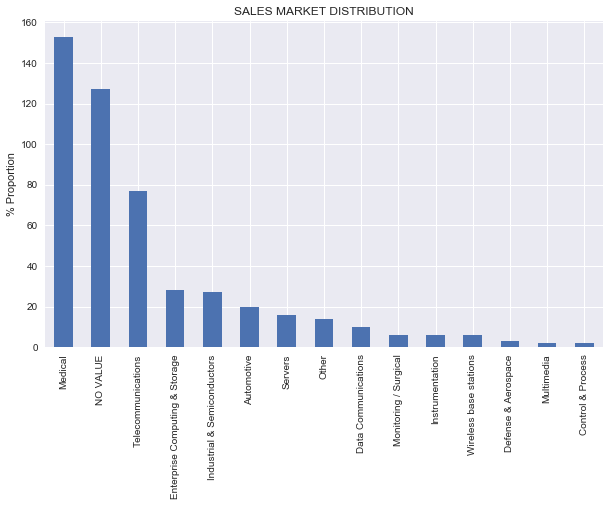

In [493]:
plt.figure(figsize=(10,6))
data['SALES_MARKET'].value_counts().plot(kind = 'bar')
plt.title('SALES MARKET DISTRIBUTION')
plt.ylabel('% Proportion')
plt.show()

#### Medical customers constitute a major proportion in our sales market

### 4. Feature engineering

In [494]:
data['new_order_date'] = pd.to_datetime(data["Order_Date"])

In [495]:
data.head()

,MASTER_CUSTOMER_NAME,OEM_NAME,SALES_MARKET,SALES_SEGMENT,FISCAL_QUARTER,MDS_VALUE,REVENUE,TakeRate,Order_Date,new_order_date
0,77 ELEKTRONIKA KFT,ROCHE DIAGNOSTICS,Medical,Monitoring - Personal,FY17-Q1,0,1806,0.000000,1/2/2017,2017-01-02
1,ATHER ENERGY PRIVATE LIMITED,ATHER ENERGY PRIVATE LIMITED,Automotive,Instrumentation,FY17-Q1,4156,0,0.000000,1/2/2017,2017-01-02
2,BLOOM ENERGY,BLOOM ENERGY,Industrial & Semiconductors,Control & Process,FY17-Q1,287205,186315,0.648718,1/2/2017,2017-01-02
3,BLOOM ENERGY,BLOOM ENERGY,Control & Process,Industrial & Semiconductors,FY17-Q1,251546,0,0.000000,1/2/2017,2017-01-02
4,BLOOM ENERGY,BLOOM ENERGY (INDIA) PVT. LTD.,Industrial & Semiconductors,Control & Process,FY17-Q1,165550,0,0.000000,1/2/2017,2017-01-02


In [496]:
print('The available Minimum date : {} and Maximum date : {}'.format(min(data["new_order_date"]), max(data["new_order_date"])))

The available Minimum date : 2017-01-02 00:00:00 and Maximum date : 2020-04-06 00:00:00


In [497]:
# Getting the latest date in the whole dataset to compute the recency parameter of the customer
latest_date = max(data["new_order_date"]) + dt.timedelta(1)
print(latest_date)

2020-04-07 00:00:00


### 4.1 RFM metrics calculation

### RFM

#### > Recency is about when was the last order placed by a customer.

#### > Frequency is about the number of times the customer has contacted for orders in a given period.

#### > Monetary is the total amount of money a customer has spent in that given period.

#### RFM Analysis is the best market analysis technique done in the industry to perform segmentation of customers.

In [498]:
data_rfm = data.groupby('MASTER_CUSTOMER_NAME').agg({
    'new_order_date' : lambda x: (latest_date - x.max()).days,
    'MDS_VALUE' : 'count', 
    'REVENUE' : 'sum'})

In [499]:
data_rfm.rename(columns={'new_order_date':'Recency','MDS_VALUE': 'Frequency','REVENUE': 'Total_Revenue'}, inplace=True)

In [500]:
data_reference = pd.DataFrame(data_rfm).reset_index()

In [501]:
data_reference.head()

,MASTER_CUSTOMER_NAME,Recency,Frequency,Total_Revenue
0,77 ELEKTRONIKA KFT,1191,1,1806
1,ABB INC,827,3,197984
2,ADVANCED MP TECHNOLOGY INC.,92,4,12352
3,AMPHENOL,456,4,22739
4,ATHER ENERGY PRIVATE LIMITED,1,11,6248051


In [502]:
data_removeExcessFreq =data[data["MDS_VALUE"]==0].groupby('MASTER_CUSTOMER_NAME').agg({'MDS_VALUE' : 'count'})

In [503]:
data_removeExcessFreq.rename(columns={'MDS_VALUE': 'Frequency'}, inplace=True)

In [504]:
data_rtest = pd.DataFrame(data_removeExcessFreq).reset_index()
data_rtest.head()

,MASTER_CUSTOMER_NAME,Frequency
0,77 ELEKTRONIKA KFT,1
1,ABB INC,1
2,ADVANCED MP TECHNOLOGY INC.,3
3,ATHER ENERGY PRIVATE LIMITED,1
4,CYIENT DLM PVT LTD,5


In [505]:
data_r = data.groupby('MASTER_CUSTOMER_NAME').agg({'new_order_date' : lambda x: (latest_date - x.max()).days}).reset_index()
data_r.rename(columns={'new_order_date':'Recency'}, inplace=True)

data_f = data.groupby('MASTER_CUSTOMER_NAME').agg({'MDS_VALUE' : 'count'}).reset_index()
data_f.rename(columns={'MDS_VALUE': 'Frequency'}, inplace=True)

data_m = data.groupby('MASTER_CUSTOMER_NAME').agg({ 'REVENUE' : 'sum'}).reset_index()
data_m.rename(columns={'REVENUE': 'Total_Revenue'}, inplace=True)

In [506]:
data_r.head()

,MASTER_CUSTOMER_NAME,Recency
0,77 ELEKTRONIKA KFT,1191
1,ABB INC,827
2,ADVANCED MP TECHNOLOGY INC.,92
3,AMPHENOL,456
4,ATHER ENERGY PRIVATE LIMITED,1


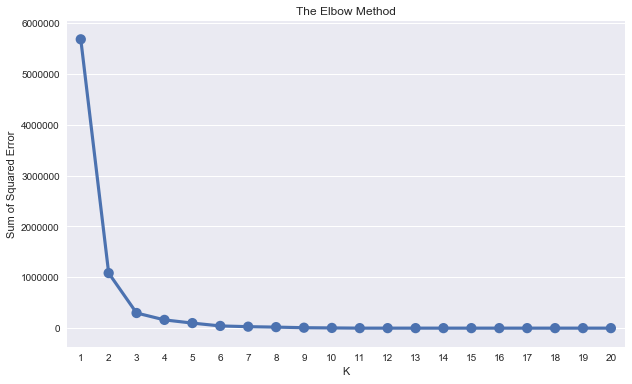

In [507]:
sse={}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state=1)
    kmeans.fit(data_r['Recency'].values.reshape(-1,1))
    sse[k] = kmeans.inertia_ 

plt.figure(figsize=(10,6))

plt.title('The Elbow Method')

plt.xlabel('K')

plt.ylabel('Sum of Squared Error')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [508]:
kmeans = KMeans(n_clusters=4,init='k-means++', random_state=1)
kmeans.fit(data_r['Recency'].values.reshape(-1,1))
data_r['RecencyCluster'] = kmeans.predict(data_r['Recency'].values.reshape(-1,1))
data_r.head()

,MASTER_CUSTOMER_NAME,Recency,RecencyCluster
0,77 ELEKTRONIKA KFT,1191,1
1,ABB INC,827,3
2,ADVANCED MP TECHNOLOGY INC.,92,0
3,AMPHENOL,456,2
4,ATHER ENERGY PRIVATE LIMITED,1,0


In [509]:
data_r.loc[data_r['RecencyCluster']==0].max()

MASTER_CUSTOMER_NAME    WIPRO TECHNOLOGIES AUSTRIA GMBH
Recency                                             183
RecencyCluster                                        0
dtype: object

In [510]:
def orderbycluster(cluster_field_name,target_field_name,data,asc):
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    data_new = data_new.sort_values(by=target_field_name,ascending=asc).reset_index(drop=True)
    data_new['index'] = data_new.index
    data_final = pd.merge(data,data_new[[cluster_field_name,'index']],on=cluster_field_name)
    data_final = data_final.drop([cluster_field_name],axis=1)
    data_final = data_final.rename(columns={'index':cluster_field_name})
    return data_final

In [511]:
data_r = orderbycluster('RecencyCluster','Recency',data_r,False)
data_r

,MASTER_CUSTOMER_NAME,Recency,RecencyCluster
0,77 ELEKTRONIKA KFT,1191,0
1,ECOPPIA SCIENTIFIC LTD,1009,0
2,KANHATECH SOLUTIONS LIMITED,918,0
3,MISSION ELECTRONICS INTERNATIONAL LIMITED,1009,0
4,RTX AS,1191,0
5,WHISTLE LABS INC,1009,0
6,ABB INC,827,1
7,NEC CORPORATION,736,1
8,SFO TECHNOLOGIES PVT LTD,645,1
9,ADVANCED MP TECHNOLOGY INC.,92,3


### 0 - Very low  recencyvalue
### 1 - Low  recencyvalue
### 2 - Medium recency value
### 3 - High recency value

In [512]:
data_reference = pd.merge(data_reference,data_r[['MASTER_CUSTOMER_NAME','RecencyCluster']],on='MASTER_CUSTOMER_NAME')

In [513]:
data_f.head()

,MASTER_CUSTOMER_NAME,Frequency
0,77 ELEKTRONIKA KFT,1
1,ABB INC,3
2,ADVANCED MP TECHNOLOGY INC.,4
3,AMPHENOL,4
4,ATHER ENERGY PRIVATE LIMITED,11


In [514]:
for cust_name in data_rtest["MASTER_CUSTOMER_NAME"]:
    #print(data_reference[data_reference["MASTER_CUSTOMER_NAME"]==cust_name]["Frequency"].item()-data_rtest[data_rtest["MASTER_CUSTOMER_NAME"]==cust_name]["Frequency"].item())
    data_f.loc[data_f["MASTER_CUSTOMER_NAME"]==cust_name,'Frequency']=(data_f[data_f["MASTER_CUSTOMER_NAME"]==cust_name]["Frequency"].item()-data_rtest[data_rtest["MASTER_CUSTOMER_NAME"]==cust_name]["Frequency"].item())
    data_reference.loc[data_f["MASTER_CUSTOMER_NAME"]==cust_name,'Frequency']=(data_reference[data_f["MASTER_CUSTOMER_NAME"]==cust_name]["Frequency"].item()-data_rtest[data_rtest["MASTER_CUSTOMER_NAME"]==cust_name]["Frequency"].item())

In [515]:
data_f.head()

,MASTER_CUSTOMER_NAME,Frequency
0,77 ELEKTRONIKA KFT,0
1,ABB INC,2
2,ADVANCED MP TECHNOLOGY INC.,1
3,AMPHENOL,4
4,ATHER ENERGY PRIVATE LIMITED,10


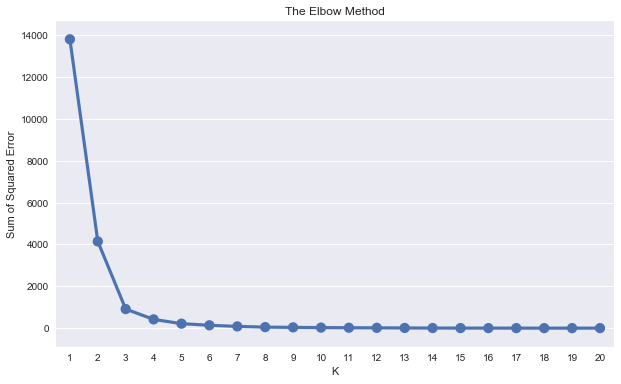

In [516]:
sse={}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state=1)
    kmeans.fit(data_f['Frequency'].values.reshape(-1,1))
    sse[k] = kmeans.inertia_ 

plt.figure(figsize=(10,6))

plt.title('The Elbow Method')

plt.xlabel('K')

plt.ylabel('Sum of Squared Error')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [517]:
kmeans = KMeans(n_clusters=4,init='k-means++', random_state=1)
kmeans.fit(data_f['Frequency'].values.reshape(-1,1))
data_f['FrequencyCluster'] = kmeans.predict(data_f['Frequency'].values.reshape(-1,1))
data_f.head()

,MASTER_CUSTOMER_NAME,Frequency,FrequencyCluster
0,77 ELEKTRONIKA KFT,0,0
1,ABB INC,2,0
2,ADVANCED MP TECHNOLOGY INC.,1,0
3,AMPHENOL,4,0
4,ATHER ENERGY PRIVATE LIMITED,10,0


In [518]:
data_f.loc[data_f['FrequencyCluster']==0].max()

MASTER_CUSTOMER_NAME    WHISTLE LABS INC
Frequency                             10
FrequencyCluster                       0
dtype: object

In [519]:
data_f = orderbycluster('FrequencyCluster','Frequency',data_f,True)
data_f

,MASTER_CUSTOMER_NAME,Frequency,FrequencyCluster
0,77 ELEKTRONIKA KFT,0,0
1,ABB INC,2,0
2,ADVANCED MP TECHNOLOGY INC.,1,0
3,AMPHENOL,4,0
4,ATHER ENERGY PRIVATE LIMITED,10,0
5,BLOOM ENERGY,7,0
6,BULL SA,5,0
7,CYIENT DLM PVT LTD,1,0
8,DERF ELECTRONICS CORP,0,0
9,ECOPPIA SCIENTIFIC LTD,2,0


### 0 - Vey low  frequency value 
### 1 - Low frequency value 
### 2 - MediumHigh frequency value 
### 3 - High frequency value 

In [520]:
data_reference= pd.merge(data_reference,data_f[['MASTER_CUSTOMER_NAME','FrequencyCluster']],on='MASTER_CUSTOMER_NAME')

In [521]:
data_m.head()

,MASTER_CUSTOMER_NAME,Total_Revenue
0,77 ELEKTRONIKA KFT,1806
1,ABB INC,197984
2,ADVANCED MP TECHNOLOGY INC.,12352
3,AMPHENOL,22739
4,ATHER ENERGY PRIVATE LIMITED,6248051


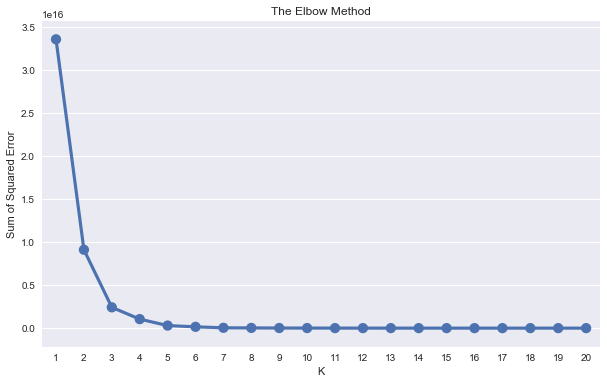

In [522]:
sse={}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=1)
    kmeans.fit(data_m['Total_Revenue'].values.reshape(-1,1))
    sse[k] = kmeans.inertia_ 

plt.figure(figsize=(10,6))

plt.title('The Elbow Method')

plt.xlabel('K')

plt.ylabel('Sum of Squared Error')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [523]:
kmeans = KMeans(n_clusters=4,init='k-means++', random_state=1)
kmeans.fit(data_m['Total_Revenue'].values.reshape(-1,1))
data_m['Total_RevenueCluster'] = kmeans.predict(data_m['Total_Revenue'].values.reshape(-1,1))
data_m.head()

,MASTER_CUSTOMER_NAME,Total_Revenue,Total_RevenueCluster
0,77 ELEKTRONIKA KFT,1806,0
1,ABB INC,197984,0
2,ADVANCED MP TECHNOLOGY INC.,12352,0
3,AMPHENOL,22739,0
4,ATHER ENERGY PRIVATE LIMITED,6248051,0


In [524]:
data_m = orderbycluster('Total_RevenueCluster','Total_Revenue',data_m,True)
data_m

,MASTER_CUSTOMER_NAME,Total_Revenue,Total_RevenueCluster
0,77 ELEKTRONIKA KFT,1806,0
1,ABB INC,197984,0
2,ADVANCED MP TECHNOLOGY INC.,12352,0
3,AMPHENOL,22739,0
4,ATHER ENERGY PRIVATE LIMITED,6248051,0
5,BLOOM ENERGY,325601,0
6,BULL SA,0,0
7,CYIENT DLM PVT LTD,200277,0
8,DERF ELECTRONICS CORP,8702,0
9,ECOPPIA SCIENTIFIC LTD,694611,0


### 0 - Very low value 
### 1 - Low value
### 2 - Medium value
### 3 - High  value 

In [525]:
data_m.loc[data_m['Total_RevenueCluster']==0].max()

MASTER_CUSTOMER_NAME    WIPRO TECHNOLOGIES AUSTRIA GMBH
Total_Revenue                                  10334944
Total_RevenueCluster                                  0
dtype: object

In [526]:
data_reference= pd.merge(data_reference,data_m[['MASTER_CUSTOMER_NAME','Total_RevenueCluster']],on='MASTER_CUSTOMER_NAME')

In [527]:
data_reference

,MASTER_CUSTOMER_NAME,Recency,Frequency,Total_Revenue,RecencyCluster,FrequencyCluster,Total_RevenueCluster
0,77 ELEKTRONIKA KFT,1191,0,1806,0,0,0
1,ABB INC,827,2,197984,1,0,0
2,ADVANCED MP TECHNOLOGY INC.,92,1,12352,3,0,0
3,AMPHENOL,456,4,22739,2,0,0
4,ATHER ENERGY PRIVATE LIMITED,1,10,6248051,3,0,0
5,BLOOM ENERGY,1,7,325601,3,0,0
6,BULL SA,1,5,0,3,0,0
7,BULL SAS,1,31,35159881,3,2,1
8,CYIENT DLM PVT LTD,456,1,200277,2,0,0
9,DERF ELECTRONICS CORP,92,0,8702,3,0,0


In [528]:
data_reference['Final_Score'] = data_reference['RecencyCluster']+data_reference['FrequencyCluster']+data_reference['Total_RevenueCluster']

In [529]:
data_reference.groupby('Final_Score')['Recency','Frequency','Total_Revenue'].mean()

,Recency,Frequency,Total_Revenue
Final_Score,,,
0,1054.500000,0.833333,1.681135e+05
1,736.000000,2.666667,1.650207e+06
2,422.400000,2.600000,1.916488e+05
3,37.400000,5.000000,8.161858e+05
4,243.666667,12.666667,1.921115e+07
5,19.200000,24.000000,1.545972e+07
6,1.000000,26.500000,4.295481e+07
7,1.000000,40.000000,7.818533e+07
9,1.000000,109.000000,1.631266e+08


In [530]:
data_reference.head()

,MASTER_CUSTOMER_NAME,Recency,Frequency,Total_Revenue,RecencyCluster,FrequencyCluster,Total_RevenueCluster,Final_Score
0,77 ELEKTRONIKA KFT,1191,0,1806,0,0,0,0
1,ABB INC,827,2,197984,1,0,0,1
2,ADVANCED MP TECHNOLOGY INC.,92,1,12352,3,0,0,3
3,AMPHENOL,456,4,22739,2,0,0,2
4,ATHER ENERGY PRIVATE LIMITED,1,10,6248051,3,0,0,3


## 5. Final dataset with customer segmentation

In [531]:
score_labels = ['Very low', 'Low', 'Medium', 'High']
score_groups = pd.qcut(data_reference["Final_Score"], q = 4, labels = score_labels)
data_reference['RFM_Level'] = score_groups.values

In [532]:
data_reference['RFM_Segment'] = data_reference.apply(lambda x: str(x['RecencyCluster']) + str(x['FrequencyCluster']) + str(x['Total_RevenueCluster']), axis = 1)

In [533]:
data_reference

,MASTER_CUSTOMER_NAME,Recency,Frequency,Total_Revenue,RecencyCluster,FrequencyCluster,Total_RevenueCluster,Final_Score,RFM_Level,RFM_Segment
0,77 ELEKTRONIKA KFT,1191,0,1806,0,0,0,0,Very low,000
1,ABB INC,827,2,197984,1,0,0,1,Very low,100
2,ADVANCED MP TECHNOLOGY INC.,92,1,12352,3,0,0,3,Low,300
3,AMPHENOL,456,4,22739,2,0,0,2,Low,200
4,ATHER ENERGY PRIVATE LIMITED,1,10,6248051,3,0,0,3,Low,300
5,BLOOM ENERGY,1,7,325601,3,0,0,3,Low,300
6,BULL SA,1,5,0,3,0,0,3,Low,300
7,BULL SAS,1,31,35159881,3,2,1,6,High,321
8,CYIENT DLM PVT LTD,456,1,200277,2,0,0,2,Low,200
9,DERF ELECTRONICS CORP,92,0,8702,3,0,0,3,Low,300
